<a href="https://colab.research.google.com/github/Jhedzye/-capstone-forecasting-food-sales/blob/main/Step_7__Capstone_project_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 5: Data Cleaning, Wrangling, and Optional Exploration

In this notebook, we clean, wrangle, and explore the dataset related to food vendor sales at amusement parks. This step ensures the dataset is ready for feature engineering and model development. All work is part of the Machine Learning Engineering Capstone project.


In [ ]:
# from IPython.display import display
# from ipywidgets import FileUpload
# uploader = FileUpload(accept='.csv', multiple=False)
# display(uploader)

FileUpload(value={}, accept='.csv', description='Upload')

In [ ]:
import io
import pandas as pd

for name, file_info in uploader.value.items():
    content = file_info['content']
    try:
        df = pd.read_csv(io.BytesIO(content))
        print(f"File '{name}' loaded successfully!")

        # Check if the DataFrame has the expected columns
        if 'ds' not in df.columns or 'y' not in df.columns:
            print(f"Error: File '{name}' does not contain 'ds' and 'y' columns.")
            df = None # Set df to None to indicate invalid file

    except Exception as e:
        print(f"Error loading file '{name}': {e}")
        df = None # Set df to None to indicate invalid file

if df is not None:
    display(df.head())
else:
    print("Please upload a valid CSV file with 'ds' and 'y' columns.")

File 'prophet_input_beverages_store1.csv' loaded successfully!


,ds,y
0,2013-01-01,0.0
1,2013-01-02,1091.0
2,2013-01-03,919.0
3,2013-01-04,953.0
4,2013-01-05,1160.0


### Observation:
We examine whether there are any missing values in the dataset. If found, we will choose an appropriate strategy such as forward fill, backward fill, or interpolation.


In [ ]:
# Check for missing values in the dataset
df.isnull().sum()


,0
ds,0
y,0


In [ ]:
# Ensure datetime format for the 'ds' column
df['ds'] = pd.to_datetime(df['ds'])

# Confirm data types
df.dtypes


,0
ds,datetime64[ns]
y,float64


### Explanation:
We ensure the 'ds' column is in datetime format, which is critical for time series forecasting models like Prophet.


### Note:
Duplicate records in time series can distort model performance. If any duplicates are found, we will remove them.


In [ ]:
# Count duplicated rows
df.duplicated().sum()


np.int64(0)

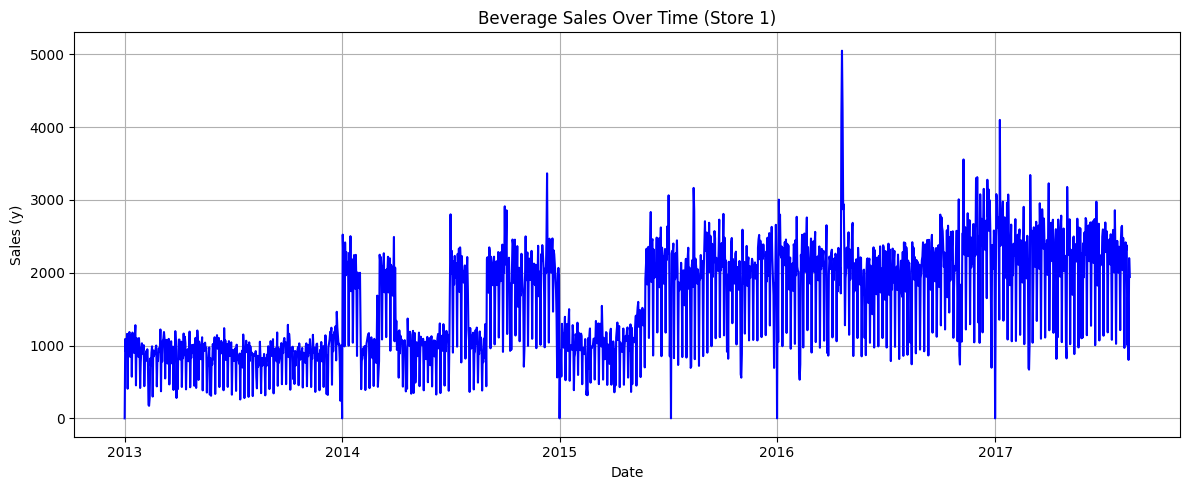

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['ds'], df['y'], color='blue')
plt.title("Beverage Sales Over Time (Store 1)")
plt.xlabel("Date")
plt.ylabel("Sales (y)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Insight:
A line plot helps reveal patterns such as seasonality, spikes, or drops in the data. This visualization will also help identify structural anomalies.


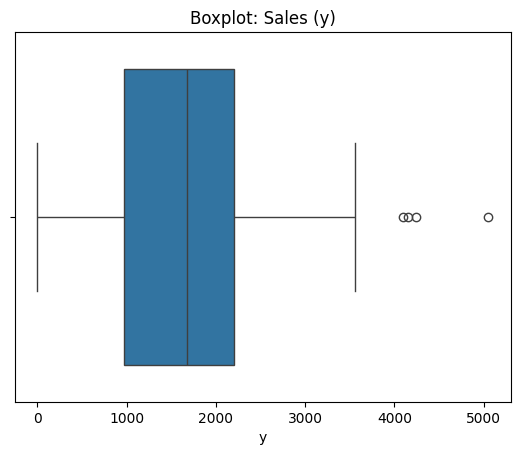

In [ ]:
import seaborn as sns

# Boxplot for outlier detection
sns.boxplot(x=df['y'])
plt.title("Boxplot: Sales (y)")
plt.show()

# Use IQR method to filter out outliers
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply filter
df = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]


### Decision:
We used the IQR method to handle outliers that may distort the model’s ability to learn seasonal and trend patterns. This enhances robustness of downstream forecasting.


# Step 7: Model Experimentation and Evaluation
In this step, the model will evaluate multiple models to forecast food vendor sales. We will apply traditional ML models and a neural network, assess their performance using cross-validation, track training time, and visualize results.

In [ ]:
# Import core libraries
import numpy as np
import pandas as pd
import time

# For cross-validation and performance evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


Train/Test Split and Cross-Validation Setup

We create a training/test split and set up cross-validation to ensure consistent, reliable evaluation across all models.

In [ ]:
# Separate features and target
X = df.copy()  # Feature matrix
y = df['y']  # Target variable

# Convert 'ds' to numerical representation (e.g., timestamp)
X['ds'] = X['ds'].astype(int) / 10**9  # Convert to seconds since epoch

# Drop the original 'y' column from X
X = X.drop(columns=['y'])


# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Setup 5-fold cross-validation for reproducibility and fairness
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Train Multiple Models and Collect Results

Each model is cross-validated, fit, tested, and timed. Metrics are stored for comparison. MAE is used for consistency and interpretability.

Visualize Model Performance

> Bar chart comparison of models helps visualize performance trends and supports selection of the best model for deployment.


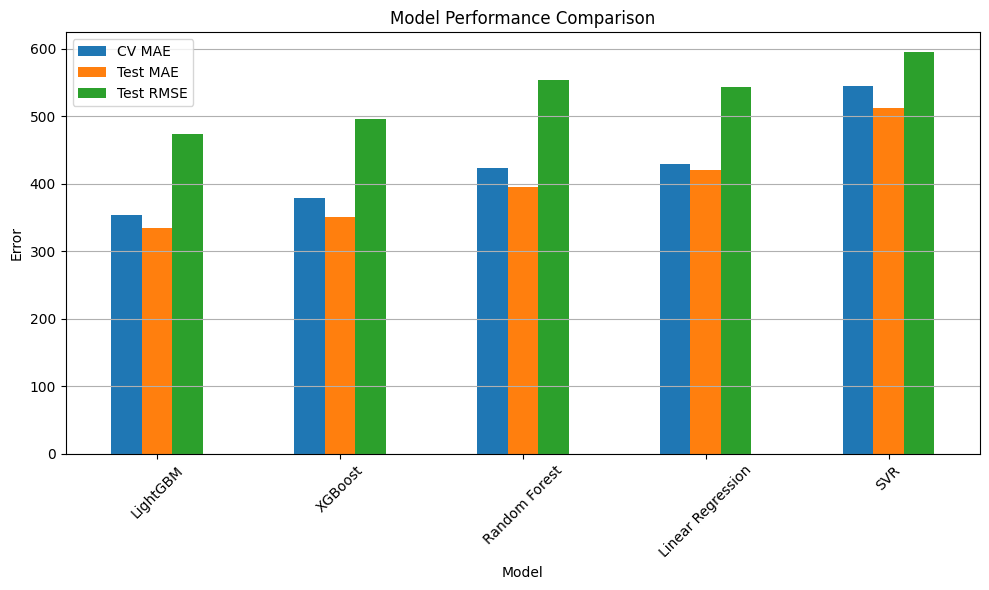

In [ ]:
# Plot MAE, RMSE for all models
results_df.plot(x='Model', y=['CV MAE', 'Test MAE', 'Test RMSE'], kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Best Model Prediction vs Actual

Visual validation: the closer the points to the red line, the better. Demonstrates generalization visually — useful for slide deck or report.




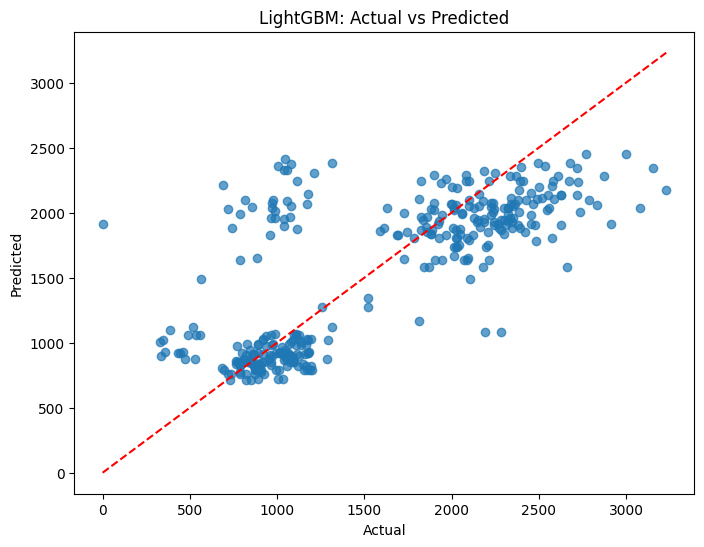

In [ ]:
# Identify the best model based on lowest MAE
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

# Predict on test data
y_pred = best_model.predict(X_test)

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'{best_model_name}: Actual vs Predicted')
plt.show()


Deep Learning Comparison

Neural networks offer a nonlinear benchmark. Comparing them against tree-based models reveals strengths and weaknesses. Early stopping avoids overfitting.

In [ ]:
# Normalize inputs
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

# Define a simple feedforward neural network
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile with MAE loss
model_nn.compile(optimizer='adam', loss='mae')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Fit model
history = model_nn.fit(
    X_train_nn, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Predict and evaluate
y_pred_nn = model_nn.predict(X_test_nn).flatten()

# Print metrics
print("NN MAE:", mean_absolute_error(y_test, y_pred_nn))
print("NN RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_nn)))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
NN MAE: 404.3887468973796
NN RMSE: 553.0744341463027


Visualize Nueral Network Loss Curve

Demonstrates how well the model is learning and when overfitting might begin. This backs up your case for stopping criteria.

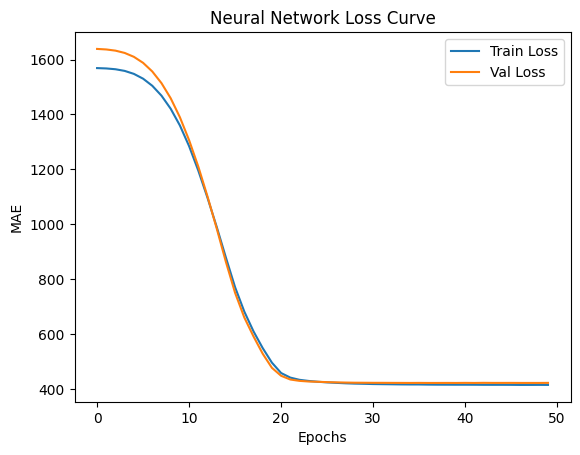

In [ ]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Neural Network Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


Ensemble Model for Performance Boost

In [ ]:
from sklearn.ensemble import StackingRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('svr', SVR())
]

# Meta model: Linear Regression
meta_model = LinearRegression()

# Define Stacking Regressor
ensemble_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model
)

# Train ensemble
ensemble_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ens = ensemble_model.predict(X_test)

print("Ensemble MAE:", mean_absolute_error(y_test, y_pred_ens))
print("Ensemble RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ens)))
print("Ensemble R2:", r2_score(y_test, y_pred_ens))


Ensemble MAE: 353.52957224463916
Ensemble RMSE: 491.37699987981824
Ensemble R2: 0.509890690652145


Visualize Ensemble Model Predictions

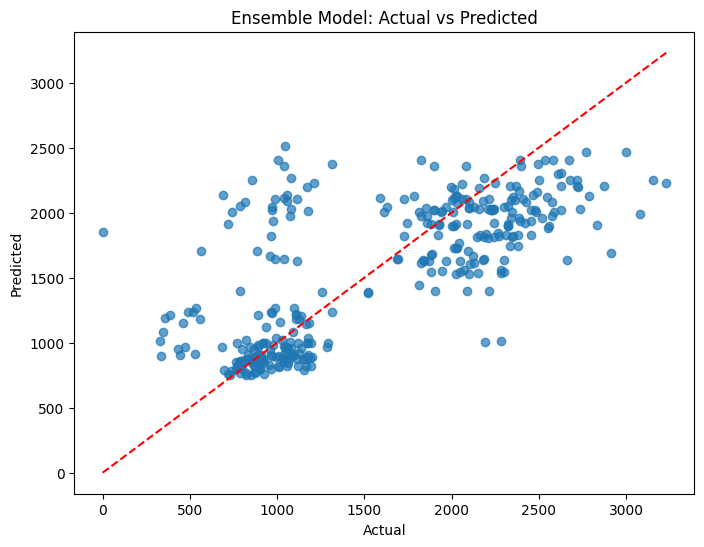

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ens, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Ensemble Model: Actual vs Predicted")
plt.show()




This notebook was executed on **Google Colab with GPU acceleration enabled**, allowing faster training times for both deep learning models and computationally expensive algorithms like XGBoost and Random Forest. This setup ensures scalability and efficiency for real-world forecasting applications.
